In [1]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Full-batch Gradient Descent
class GDClassifier:
    def __init__(self, loss="log", lr=0.01, lam=1e-3, max_iter=10000, tol=1e-7, verbose=0):
        self.loss = loss
        self.lr = lr
        self.max_iter = max_iter
        self.verbose = verbose
        self.w = None
        self.bias = 0
        self.losses_ = []
        self.tol = tol
        self.lam = lam

    def _compute_loss(self, X, y):
        pred = X @ self.w + self.bias
        if self.loss == "squared":
            return np.mean((y - pred) ** 2) + 0.5 * self.lam * np.sum(self.w**2)
        elif self.loss == "log":
            z = pred * (2*y - 1)  # y in {0,1} -> {-1,1}
            return np.mean(np.log(1 + np.exp(-z))) + 0.5 * self.lam * np.sum(self.w**2)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.random.randn(n_features) * 0.01
        self.bias = 0

        for it in range(1, self.max_iter + 1):
            # Predictions on full batch
            pred = X @ self.w + self.bias

            # Gradient (full-batch)
            if self.loss == "squared":
                # Mean gradient for stability
                err = (y - pred)
                grad_w = -2 * (X.T @ err) / n_samples + self.lam * self.w
                grad_b = -2 * np.mean(err)
            elif self.loss == "log":
                # y in {0,1}; logistic gradient
                p = 1 / (1 + np.exp(-pred))
                diff = (p - y)
                grad_w = (X.T @ diff) / n_samples + self.lam * self.w
                grad_b = np.mean(diff)

            # Update
            self.w -= self.lr * grad_w
            self.bias -= self.lr * grad_b

            # Record loss occasionally
            if it % 10 == 0:
                l = self._compute_loss(X, y)
                self.losses_.append(l)
                if self.verbose:
                    print(f"iter {it}, loss={l:.6f}")
                if len(self.losses_) > 1 and abs(self.losses_[-1] - self.losses_[-2]) < self.tol:
                    print(f"Converged at {it}")
                    break
        return self

    def predict_proba(self, X):
        pred = X @ self.w + self.bias
        if self.loss == "log":
            p = 1 / (1 + np.exp(-pred))
            return np.stack([1-p, p], axis=1)
        return pred

    def predict(self, X):
        if self.loss == "log":
            return (self.predict_proba(X)[:,1] >= 0.5).astype(int)
        else:
            return (self.predict_proba(X) >= 0.5).astype(int)


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

# Fetch dataset (same as SGD.ipynb)
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = (bank_marketing.data.targets == "yes").astype(int)  # convert yes/no -> 1/0

# One-hot encode categorical features
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values.ravel(), test_size=0.2, random_state=42
)


In [3]:
# Train GD with squared loss to mirror prior run
gd_classifier = GDClassifier(loss="squared", lr=1e-2, max_iter=5000, verbose=0, lam=1e-3)
gd_classifier.fit(X_train, y_train)

Converged at 1050


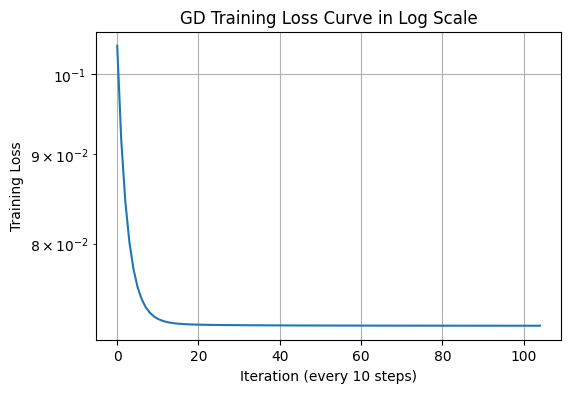

In [4]:
# Loss curve (log scale)
plt.figure(figsize=(6,4))
plt.plot(gd_classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("GD Training Loss Curve in Log Scale")
plt.yscale('log')
plt.grid(True)
plt.show()


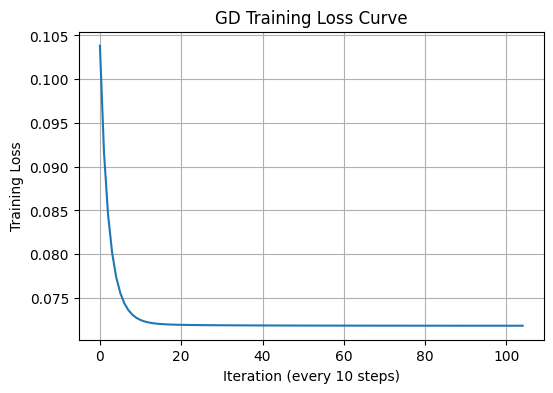

In [5]:
# Loss curve (linear)
plt.figure(figsize=(6,4))
plt.plot(gd_classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("GD Training Loss Curve")
plt.grid(True)
plt.show()


In [6]:
# Test accuracy
y_pred = gd_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8967156916952339
